# AFL Match Predictors

In [1]:
from matplotlib import pyplot as plt
plt.style.use(['mvstyle', 'one_piece'])

import numpy as np
import pandas as pd



## Data Processing 

In [2]:
import libs.data_processing as dp

Check if data needs to be retrieved from the API

In [3]:
dp.get_standings()
dp.get_seasonal_data()
dp.get_standings()

Combine all seasonal data into one DataFrame

In [4]:
full_data = dp.process_data()

In [5]:
full_data.iloc[-1]

round             2.0
hteamid          17.0
ateamid           8.0
hrank            17.0
arank            11.0
hscore_ppg       49.0
ascore_ppg      136.0
hgoals_ppg        7.0
agoals_ppg       20.0
hbehinds_ppg      7.0
abehinds_ppg     16.0
hwins             0.0
awins             0.0
hlosses           0.0
alosses           0.0
is_final          0.0
hteamwin          0.0
Name: 10, dtype: float64

## Neural Nets

In [7]:
import libs.neural_nets as mnn
import torch.nn as nn
import torch.optim as optim

### Process data for use in neural nets

In [8]:
main_data = mnn.PandasDataset(full_data)


train_proportion = 0.7
val_proportion = 1.0 - train_proportion

batch_size = 100

train_data, val_data = mnn.train_test_split(main_data, train_size=train_proportion, shuffle=True, random_state=42)

train_loader = mnn.DataLoader(train_data, 
                          shuffle=True, 
                          num_workers=2, 
                          batch_size=batch_size
                          )

val_loader = mnn.DataLoader(val_data, 
                        shuffle=True, 
                        num_workers=2, 
                        batch_size=batch_size
                        )

Test speed of data loader

In [9]:
import time
tstart=time.time()
num_iter=100
ctr=num_iter
for batch in train_loader:
    ctr -=100
    if ctr <= 0: break
print((time.time()-tstart)/num_iter,'[s/iteration]')

0.010378611087799073 [s/iteration]


### Dense Neural Net

Define the neural network architecture

In [45]:
hidden_nodes = 10
output_nodes = 3
hidden_layers = 3

input_num = main_data[0][0].__len__()
model = mnn.DenseNN(input_num, hidden_nodes, output_nodes, hidden_layers)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):

  print("In epoch: ", epoch)
  
  running_loss_train = []
  running_loss_val = []
  
  index = 0
  
  for batch in train_loader:
      
      index = index + 1
      inputs, labels = batch

      optimizer.zero_grad()

      # Forward propagation
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      # Backward propagation and optimize
      loss.backward()
      optimizer.step()
      running_loss_train.append(loss.item())

      if index % 10 == 9:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_train)))

  print("End train epoch, mean loss: ", np.mean(np.asarray(running_loss_train)))
  index = 0
  for batch in val_loader:
      index = index+1
      inputs, labels = batch
      # labels = labels.view(-1, 1) 
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      running_loss_val.append(loss.item())
      if index % 10 == 9:    # Print every 100 mini-batches
        print("batch: ", index, " loss = " , np.mean(np.asarray(running_loss_val)))

  print("End val epoch, mean loss: ", np.mean(np.asarray(running_loss_val)))

print('Finished Training')

In epoch:  0


batch:  9  loss =  1.227190203136868
batch:  19  loss =  1.1625134568465383
batch:  29  loss =  1.1286624094535564
batch:  39  loss =  1.1075608287102137
batch:  49  loss =  1.0874322105427177
batch:  59  loss =  1.0704359028298975
End train epoch, mean loss:  1.0567057808833336
batch:  9  loss =  0.9367124173376296
batch:  19  loss =  0.9318839405712328
batch:  29  loss =  0.9293567394388134
End val epoch, mean loss:  0.9293567394388134
In epoch:  1
batch:  9  loss =  0.8990218506919013
batch:  19  loss =  0.8724566164769625
batch:  29  loss =  0.8467323677293186
batch:  39  loss =  0.8229612738658221
batch:  49  loss =  0.8023438940242845
batch:  59  loss =  0.7883226800773103
End train epoch, mean loss:  0.7768087262537942
batch:  9  loss =  0.6979796820216708
batch:  19  loss =  0.715046719500893
batch:  29  loss =  0.7193501283382547
End val epoch, mean loss:  0.7193501283382547
In epoch:  2
batch:  9  loss =  0.7514946990542941
batch:  19  loss =  0.7348738626429909
batch:  29  l

Model working at 78.2% accuracy


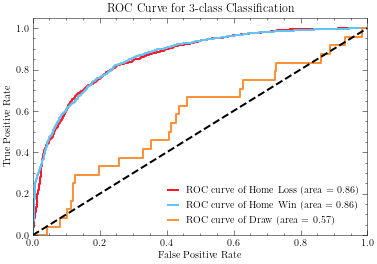

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_target = []
y_pred = []
for batch in val_loader:
      
      inputs, labels = batch
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      numpy_array = outputs.detach().numpy()
      y_target.extend(labels.numpy())
      y_pred.extend(numpy_array)


y_target = np.array(y_target)  # Example true labels
y_pred = np.array(y_pred)

pred_vals = [x.argmax() for x in y_pred]
mask = pred_vals == y_target
accuracy = mask.sum()/len(mask) * 100
print(f'Model working at {accuracy:0.1f}% accuracy')


target_labels = ["Home Loss", "Home Win", "Draw"]

def plot_roc_curve(y_true, y_pred_prob):

    # Binarize the labels
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

    column_sums = np.sum(y_true_binarized, axis=0)
    # print(column_sums)
    # print(y_true_binarized)
    # print(y_pred_prob)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(target_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    # colors = ['blue', 'red', 'green', 'orange']
    for i in range(len(target_labels)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(target_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 3-class Classification')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_target, y_pred)

Save the trained model for later use

In [15]:
from torch import save

save(model.state_dict(), 'AFL_prediction_model_DNN.pth')

## Predicting upcoming games

Predict the winners for the round!

In [1]:
%run "./libs/predictors.py"

Hawthorn to win with 0.59 probability
Western Bulldogs to win with 0.74 probability
Essendon to win with 0.78 probability
Port Adelaide to win with 0.98 probability
Geelong to win with 0.88 probability
Brisbane Lions to win with 0.98 probability
Melbourne to win with 0.86 probability
Sydney to win with 0.87 probability
